# Analysis of population in Catalonia.
Manel Lopez Melia.

## 1. Introduction.

The aim of this project is to explore data of population and demographics of Catalonia.

### Source.

All datasets in this work can be downloaded at https://www.idescat.cat/serveis/consultes/. There are four different datasets:

- 'p2018_municipis_any_any.csv', population of each town in Catalonia for all ages in 1 year bins.
- 'p2018_municipis_quinquenal.csv', population of each town in Catalonia for all ages in 5 years bins.
- 'p2018_municipis_llnaix.csv', population of each town in Catalonia classified by place of birth.
- 'p2018_municipis_nacio.csv', population of each town in Catalonia classified by nationality.

### Packages.

The packages that will be used are:

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 2. Exploratory Data Analysis.

The first dataset, 'p2018_municipis_any_any.csv', contains the population of each town in Catalonia in 1 year bins. Executing

!head 'data/p2018_municipis_any_any.csv'

we can skim over the first 10 lines of this file and notice some details, like that the first 3 rows can be skipped or that the separation symbol between columns is ';'. This has to be taken into account when reading the file:

In [2]:
filename = 'data/p2018_municipis_any_any.csv'

indices = ['Municipi', 'Edats']
columns = ['Homes', 'Dones', 'Total']

pop1yr = pd.read_csv(filename, skiprows=3, sep=';', thousands='.', encoding='latin1', usecols=indices+columns)
pop1yr = pop1yr.set_index(indices)
pop1yr = pop1yr.dropna()

Now this DataFrame can be explored with the typical commands: pop1yr.info(), pop1yr.describe(), pop1yr.head(), pop1yr.tail(), pop1yr.sample().

But let's proceed to more interesting steps and take two subsets of pop1yr: the population of the cities of Barcelona and Olot.

In [3]:
bcntotal = pop1yr.loc[' Barcelona', ' Total']['Total']

bcn1yr = pop1yr.loc[' Barcelona', :]
bcn1yr = bcn1yr.loc[' De 0 anys':' De 100 anys i més']
bcn1yr = bcn1yr / bcntotal * 100

olottotal = pop1yr.loc[' Olot', ' Total']['Total']

olot1yr = pop1yr.loc[' Olot', :]
olot1yr = olot1yr.loc[' De 0 anys':' De 100 anys i més']
olot1yr = olot1yr / olottotal * 100

index = pd.Index([i for i in range(101)])
bcn1yr = bcn1yr.set_index(index)
olot1yr = olot1yr.set_index(index)

print('Barcelona is the capital of Catalonia, with a total population of {:.0f} inhabitants.'.format(bcntotal))
print('Olot is the capital of the county of La Garrotxa, and has {:.0f} inhabitants.'.format(olottotal))

Barcelona is the capital of Catalonia, with a total population of 1620343 inhabitants.
Olot is the capital of the county of La Garrotxa, and has 34486 inhabitants.


The population of both these cities has been scaled to their respective totals. These way, the percentage of each bin can be easily compared:

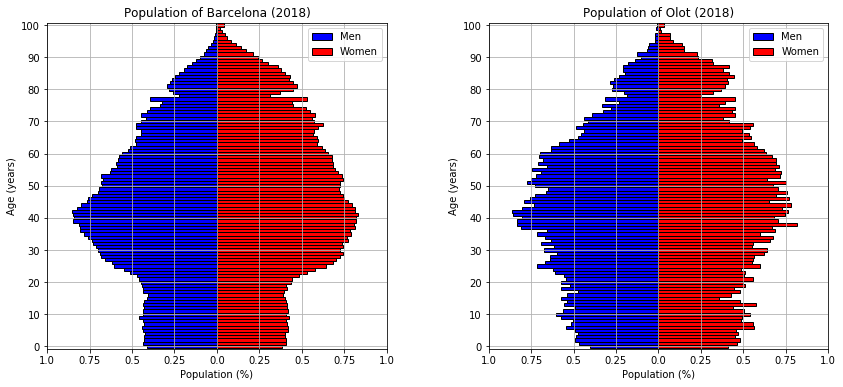

In [4]:
fig = plt.figure(figsize=(14, 6))
plt.subplots_adjust(wspace=0.3)

fig.add_subplot(121)
plt.title('Population of Barcelona (2018)')
plt.xlabel('Population (%)')
plt.ylabel('Age (years)')
bcn1yr['Homes'].apply(lambda x: -x).plot.barh(color='blue', edgecolor='black', label='Men', width=1)
bcn1yr['Dones'].plot.barh(color='red', edgecolor='black', label='Women', width=1)
locs = [-1.00, -0.75, -0.50, -0.25, 0, 0.25, 0.50, 0.75, 1.00]
plt.xticks(locs, np.abs(locs))
plt.yticks(np.arange(0, 101, 10), np.arange(0, 101, 10))
plt.legend()
plt.grid()

fig.add_subplot(122)
plt.title('Population of Olot (2018)')
plt.xlabel('Population (%)')
plt.ylabel('Age (years)')
olot1yr['Homes'].apply(lambda x: -x).plot.barh(color='blue', edgecolor='black', label='Men', width=1)
olot1yr['Dones'].plot.barh(color='red', edgecolor='black', label='Women', width=1)
plt.xticks(locs, np.abs(locs))
plt.yticks(np.arange(0, 101, 10), np.arange(0, 101, 10))
plt.legend()
plt.grid()

plt.show()

The purpose of this comparison is to show how the population bins of Olot are far more irregular than those of Barcelona. This is because Barcelona has more inhabitants, around 1.5 M, and Olot only has 35 k, approximately. Just like taking a random sample of some distribution, the bigger your sample, the smoother the distribution.

Now we could focus on the shape of these population pyramids, the baby-boom effect, et cetera, but first, let's find a way to *fix* the problem of these irregularities in Olot's population.

The problem is not Olot itself, as commented, but the fact that it has not enought inhabitants to have smooth statistics. As in this project we will work with almost all towns in Catalonia, we have to find a way to *fix* these irregularities. The solution is simple: gather the bins in groups of 5.

In [5]:
groups_of = 5

mask = np.arange(len(bcn1yr)) // groups_of
bcn5yr = bcn1yr.groupby(mask).sum()
olot5yr = olot1yr.groupby(mask).sum()

array = [str(5*i) + ' to ' + str(5*i + 4) for i in range(20)] + ['100 or +']
index = pd.Index(array)
bcn5yr = bcn5yr.set_index(index)
olot5yr = olot5yr.set_index(index)

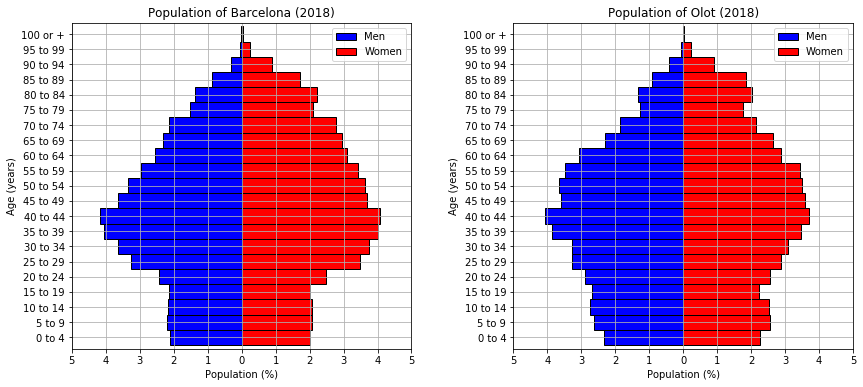

In [6]:
fig = plt.figure(figsize=(14, 6))
plt.subplots_adjust(wspace=0.3)

fig.add_subplot(121)
plt.title('Population of Barcelona (2018)')
plt.xlabel('Population (%)')
plt.ylabel('Age (years)')
bcn5yr['Homes'].apply(lambda x: -x).plot.barh(color='blue', edgecolor='black', label='Men', width=1)
bcn5yr['Dones'].plot.barh(color='red', edgecolor='black', label='Women', width=1)
locs = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
plt.xticks(locs, np.abs(locs))
plt.yticks(np.arange(0, 21, 1), array)
plt.legend()
plt.grid()

fig.add_subplot(122)
plt.title('Population of Olot (2018)')
plt.xlabel('Population (%)')
plt.ylabel('Age (years)')
olot5yr['Homes'].apply(lambda x: -x).plot.barh(color='blue', edgecolor='black', label='Men', width=1)
olot5yr['Dones'].plot.barh(color='red', edgecolor='black', label='Women', width=1)
plt.xticks(locs, np.abs(locs))
plt.yticks(np.arange(0, 21, 1), array)
plt.legend()
plt.grid()

plt.show()

Much better: now we don't have all the information, we lost precision, BUT Olot's population has no noise anymore.

This was to show how one could proceed with a dataset with 1 year bins. In this case, though, we are lucky that there is already a file that contains the population of all towns in Catalonia in 5 year bins:

In [7]:
filename = 'data/p2018_municipis_quinquenal.csv'
indices = ['Municipi', 'Edat']
columns = ['Homes', 'Dones', 'Total']

pop5yr = pd.read_csv(filename, skiprows=3, sep=';', thousands='.', encoding='latin1', usecols=indices+columns)
pop5yr = pop5yr.set_index(indices)
pop5yr = pop5yr.dropna()

Let's take the Barcelona and Olot subsets again:

In [8]:
bcntotal = pop5yr.loc[' Barcelona', ' Total']['Total']

bcn5yr = pop5yr.loc[' Barcelona', :]
bcn5yr = bcn5yr.loc[' De 0 a 4 anys':' De 100 anys i més']
bcn5yr = bcn5yr / bcntotal * 100

olottotal = pop5yr.loc[' Olot', ' Total']['Total']

olot5yr = pop5yr.loc[' Olot', :]
olot5yr = olot5yr.loc[' De 0 a 4 anys':' De 100 anys i més']
olot5yr = olot5yr / olottotal * 100

array = [str(5*i) + ' to ' + str(5*i + 4) for i in range(20)] + ['100 or +']
index = pd.Index(array)
bcn5yr = bcn5yr.set_index(index)
olot5yr = olot5yr.set_index(index)

and do some plots:

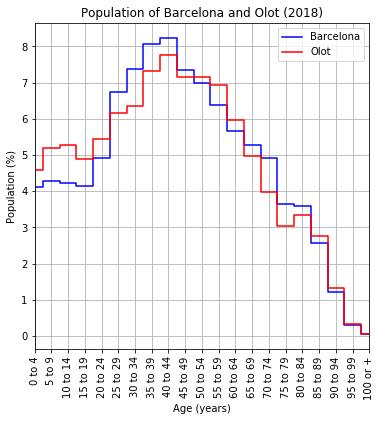

In [9]:
plt.figure(figsize=(6, 6))

plt.title('Population of Barcelona and Olot (2018)')
plt.xlabel('Age (years)')
plt.ylabel('Population (%)')
bcn5yr['Total'].plot(color='blue', drawstyle='steps-mid', label='Barcelona')
olot5yr['Total'].plot(color='red', drawstyle='steps-mid', label='Olot')
plt.xticks(range(len(array)), array, rotation=90)
locs = [0, 1, 2, 3, 4, 5, 6, 7, 8]
plt.yticks(locs)
plt.legend()
plt.grid()

plt.show()

Plotted this way, its much easier to compare these two cities.

For instance, it looks like Olot has a greater percentage of population than Barcelona for ages from 0 to 24 years, with differences reaching almost 1%.